# Source localization with MNE/dSPM/sLORETA

The aim of this lecture is to teach you how to compute and apply
a linear inverse method such as MNE/dSPM/sLORETA on evoked/raw/epochs data.

`
Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
         Denis Engemann <denis.engemann@gmail.com>
`

In [2]:
# add plot inline in the page
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import mne
mne.set_log_level('WARNING')

## Process MEG data

In [3]:
from mne.datasets import sample
# data_path = sample.data_path()
data_path = '/Users/alex/mne_data/MNE-sample-data'

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname)
print(raw)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~3.6 MB, data not loaded>


Looking at meta data, a.k.a. measurement info, such sampling frequency, channels etc.

In [4]:
print(raw.info['sfreq'])

150.15374755859375


### Define epochs and compute ERP/ERF

First look for events / triggers

In [5]:
events = mne.find_events(raw, stim_channel='STI 014')

In [7]:
event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True, exclude='bads')
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject)
epochs.drop_bad()
print(epochs.selection.shape)
print(epochs)

(55,)
<Epochs  |  n_events : 55 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0), ~3.5 MB, data not loaded>


## Compute noise covariance

See

Engemann D.A., Gramfort A., Automated model selection in covariance estimation and spatial whitening of MEG and EEG signals, Neuroimage. 2015 Mar

In [8]:
noise_cov = mne.compute_covariance(epochs, tmax=0.,
                                   method=['shrunk', 'empirical'])
print(noise_cov.data.shape)

(305, 305)


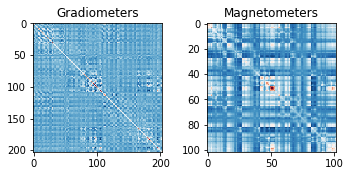

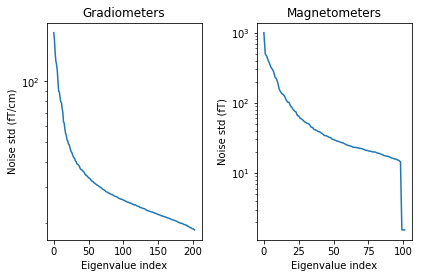

(<matplotlib.figure.Figure at 0x106ca9d30>,
 <matplotlib.figure.Figure at 0x10ff602b0>)

In [9]:
mne.viz.plot_cov(noise_cov, raw.info)

## Compute the evoked response

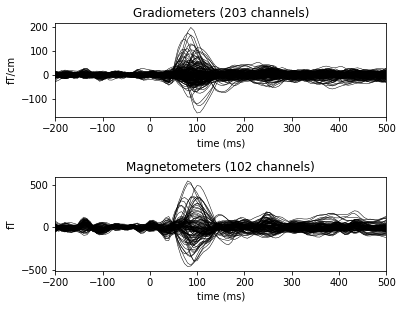

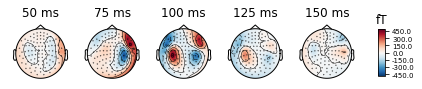

In [10]:
evoked = epochs.average()
evoked.plot()
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag');

# Show whitening

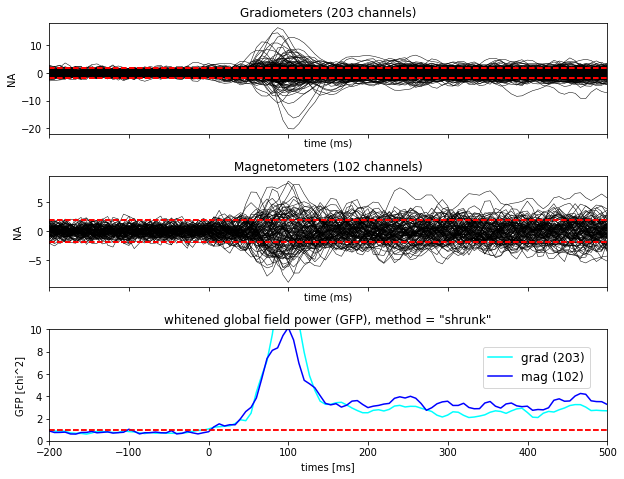

In [11]:
evoked.plot_white(noise_cov);

## Inverse modeling with MNE and dSPM on evoked and raw data

Import the required functions:

In [12]:
from mne.forward import read_forward_solution
from mne.minimum_norm import (make_inverse_operator, apply_inverse,
                              write_inverse_operator)

## Read the forward solution and compute the inverse operator

MNE/dSPM/sLORETA lead to linear inverse model than are independant
from the data (just the noise covariance) and can therefore be
precomputed and applied to data in a later stage.

In [14]:
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd, surf_ori=True)

# Restrict forward solution as necessary for MEG
fwd = mne.pick_types_forward(fwd, meg=True, eeg=False)

# make an M/EEG, MEG-only, and EEG-only inverse operators
info = evoked.info
inverse_operator = make_inverse_operator(info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

write_inverse_operator('sample_audvis-meg-oct-6-inv.fif',
                       inverse_operator)

## Compute inverse solution / Apply inverse operators

In [15]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2,
                    method=method, pick_ori=None)
print(stc)

<SourceEstimate  |  7498 vertices, subject : sample, tmin : -199.79521315838787 (ms), tmax : 499.488032896 (ms), tstep : 6.659840438612929 (ms), data size : 7498 x 106>


In [16]:
stc.data.shape

(7498, 106)

In [17]:
stc.save('fixed_ori')

In [15]:
# make one with no orientation constraint (free orientation)
# inverse_operator = make_inverse_operator(info, fwd, noise_cov,
#                                          loose=1., depth=0.8)
# stc = apply_inverse(evoked, inverse_operator, lambda2,
#                     method=method, pick_ori=None)
# stc.save('free_ori')

The STC (Source Time Courses) are defined on a source space formed by 7498 candidate
locations and for a duration spanning 106 time instants.

## Show the result

In [16]:
subjects_dir = data_path + '/subjects'
brain = stc.plot(surface='inflated', hemi='rh', subjects_dir=subjects_dir)
brain.set_data_time_index(45)
brain.scale_data_colormap(fmin=8, fmid=12, fmax=15, transparent=True)
brain.show_view('lateral')

((-7.0167092985348768e-15, 90.0, 518.46453857421875, array([ 0.,  0.,  0.])),
 -90.0)

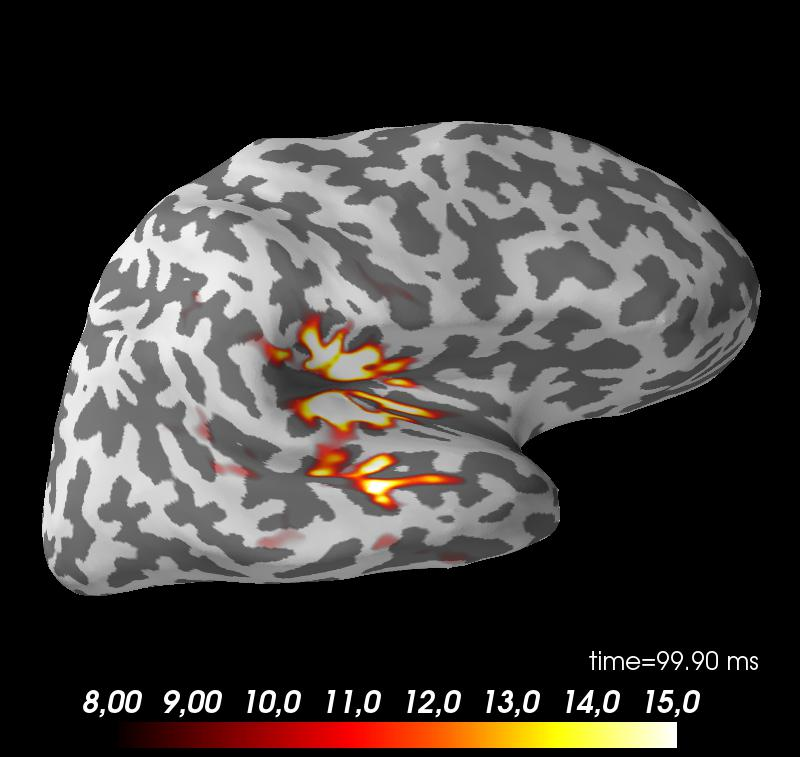

In [17]:
brain.save_image('dspm.jpg')
from IPython.display import Image
Image(filename='dspm.jpg', width=600)

## Morphing data to an average brain for group studies

In [18]:
subjects_dir = data_path + '/subjects'
stc_fsaverage = stc.morph(subject_to='fsaverage', subjects_dir=subjects_dir)

In [19]:
stc_fsaverage.save('fsaverage_dspm')

NameError: name 'stc_fsaverage' is not defined

In [ ]:
brain_fsaverage = stc_fsaverage.plot(surface='inflated', hemi='rh',
                                     subjects_dir=subjects_dir)
brain_fsaverage.set_data_time_index(45)
brain_fsaverage.scale_data_colormap(fmin=8, fmid=12, fmax=15, transparent=True)
brain_fsaverage.show_view('lateral')

In [ ]:
brain_fsaverage.save_image('dspm_fsaverage.jpg')
from IPython.display import Image
Image(filename='dspm_fsaverage.jpg', width=600)

### Solving the inverse problem on raw data or epochs using Freesurfer labels

In [ ]:
fname_label = data_path + '/MEG/sample/labels/Aud-lh.label'
label = mne.read_label(fname_label)

Compute inverse solution during the first 15s:

In [ ]:
from mne.minimum_norm import apply_inverse_raw, apply_inverse_epochs

start, stop = raw.time_as_index([0, 15])  # read the first 15s of data

stc = apply_inverse_raw(raw, inverse_operator, lambda2, method, label,
                        start, stop)

Plot the dSPM time courses in the label

In [ ]:
%matplotlib inline
plt.plot(stc.times, stc.data.T)
plt.xlabel('time (s)')
plt.ylabel('dSPM value')

And on epochs:

In [ ]:
# Compute inverse solution and stcs for each epoch
# Use the same inverse operator as with evoked data (i.e., set nave)
# If you use a different nave, dSPM just scales by a factor sqrt(nave)

stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method, label,
                            pick_ori="normal", nave=evoked.nave)

stc_evoked = apply_inverse(evoked, inverse_operator, lambda2, method,
                           pick_ori="normal")

stc_evoked_label = stc_evoked.in_label(label)

# Mean across trials but not across vertices in label
mean_stc = np.sum(stcs) / len(stcs)

In [ ]:
# compute sign flip to avoid signal cancelation when averaging signed values
flip = mne.label_sign_flip(label, inverse_operator['src'])

label_mean = np.mean(mean_stc.data, axis=0)
label_mean_flip = np.mean(flip[:, np.newaxis] * mean_stc.data, axis=0)

# Average over label (not caring to align polarities here)
label_mean_evoked = np.mean(stc_evoked_label.data, axis=0)

View activation time-series to illustrate the benefit of aligning/flipping

In [ ]:
times = 1e3 * stcs[0].times  # times in ms

plt.figure()
h0 = plt.plot(times, mean_stc.data.T, 'k')
h1, = plt.plot(times, label_mean, 'r', linewidth=3)
h2, = plt.plot(times, label_mean_flip, 'g', linewidth=3)
plt.legend((h0[0], h1, h2), ('all dipoles in label', 'mean',
                             'mean with sign flip'))
plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.show()

Viewing single trial dSPM and average dSPM for unflipped pooling over label
Compare to (1) Inverse (dSPM) then average, (2) Evoked then dSPM

In [ ]:
# Single trial
plt.figure()
for k, stc_trial in enumerate(stcs):
    plt.plot(times, np.mean(stc_trial.data, axis=0).T, 'k--',
             label='Single Trials' if k == 0 else '_nolegend_',
             alpha=0.5)

# Single trial inverse then average.. making linewidth large to not be masked
plt.plot(times, label_mean, 'b', linewidth=6,
         label='dSPM first, then average')

# Evoked and then inverse
plt.plot(times, label_mean_evoked, 'r', linewidth=2,
         label='Average first, then dSPM')

plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.legend()
plt.show()

## Exercises
- Run sLORETA on the same data and compare source localizations
- Run an LCMV beamformer on the same data and compare source localizations

### Going further:
- http://martinos.org/mne/dev/auto_examples/inverse/plot_compute_mne_inverse_epochs_in_label.html
- http://martinos.org/mne/dev/auto_examples/inverse/plot_label_source_activations.html
- http://martinos.org/mne/dev/auto_examples/inverse/plot_label_from_stc.html